<a href="https://colab.research.google.com/github/shilpisirohi12/bootcamp/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project #2 - Unsupervised learning and dimensionality reduction using autoencoders**

**1) Import libraries**

*   **numpy** for data manipulation
*   **matplotlib** for data visualization
*   **tensorflow** for neural network conception and training
*   **urllib** and **csv** to download and parse data

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import urllib.request
import csv

**2) Download and parse data**

Download the first N house votes and create vectors of votes per representative. Save parties as class labels. This step may take a few minutes.

In [2]:
N = 100

# valid types of vote
votes = {'Yea': 1, 'Nay': -1, 'Aye': 1, 'No': -1}
# known parties
parties = {'Republican': 0, 'Democrat': 1}
# votes per politician
votes_per_person = {}

for i in range(N):
  # read the CSV file of a house vote, discard the top 2 lines (description and header)
  with urllib.request.urlopen('https://www.govtrack.us/congress/votes/116-2020/h'+str(i+1)+'/export/csv') as fp:
    lines = fp.readlines()[2:]

  for line in lines:
    # get fields of interest
    [[_, state, _, vote, name, party]] = list(csv.reader([line.decode('utf-8')]))

    # check if vote is valid
    if vote not in votes:
      vote = 0
    else:
      vote = votes[vote]

    # check if party is known
    if party not in parties:
      party = len(parties)
    else:
      party = parties[party]

    # save vote in the i-th column
    if name not in votes_per_person:
      votes_per_person[name] = {'state': state, 'party': party, 'votes': [0]*i + [vote]}
    else:
      votes_per_person[name]['votes'] += [0]*(i-len(votes_per_person[name]['votes'])) + [vote]

# pad zeros to vector of votes until its size is N
for name in votes_per_person:
	votes_per_person[name]['votes'] += [0]*(N-len(votes_per_person[name]['votes']))

# organize data into arrays
X = np.zeros((len(votes_per_person), N), dtype=np.float32)
Y = np.zeros((len(votes_per_person),), dtype=np.int32)
names = []

for i, (name, data) in enumerate(sorted(votes_per_person.items())):
  names.append(name)
  Y[i] = data['party']
  X[i] = np.asarray(data['votes'])

**3) Visualize data**

Show some data statistics and all votes for some representatives.

Number of house votes: 100
Number of house representatives: 437
Average number of votes per representative: 92.77574

 Commish. Jenniffer González-Colón [R]


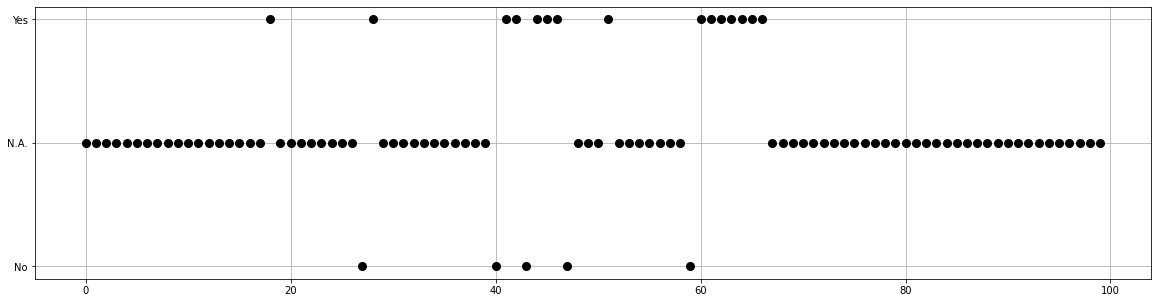


 Rep. A. Dutch Ruppersberger [D]


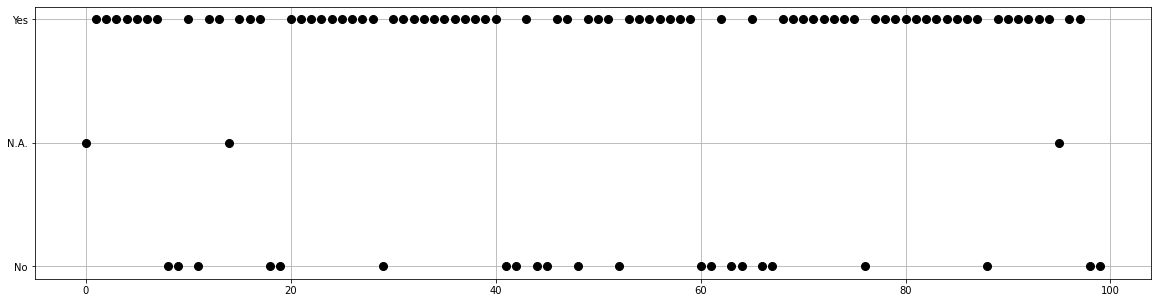


 Rep. Abby Finkenauer [D]


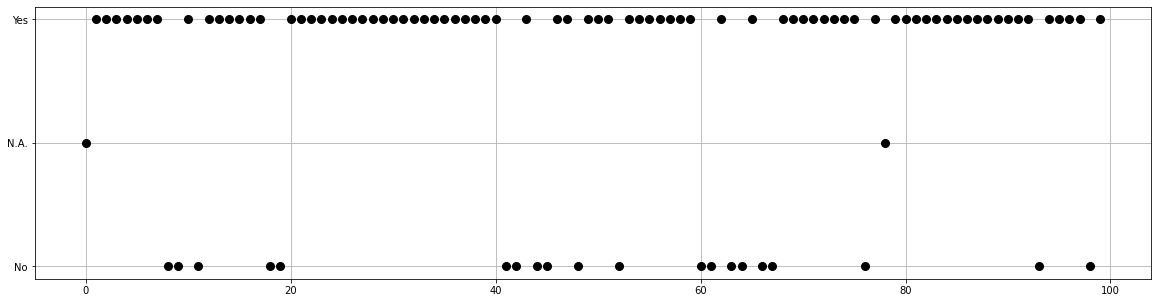

In [3]:
def show_votes(v, r=None):
  plt.rcParams["figure.figsize"] = (20,5)
  plt.yticks((-1,0,1), ('No', 'N.A.', 'Yes'))
  plt.ylim((-1.1, 1.1))
  plt.grid()
  plt.plot(x, v, 'ko', markersize=8)
  if r is not None:
    plt.plot(x, r, 'ro', markersize=5)
  plt.show()

print('Number of house votes:', N)
print('Number of house representatives:', len(X))
print('Average number of votes per representative:', np.mean(np.sum(np.square(X), axis=1)))

# show votes of the first 3 representatives (alphabetical order)
x = [i for i in range(N)]
for i in range(3):
  print('\n', names[i])
  show_votes(X[i])

**4) Define autoencoder architecture**

![Autoencoder](https://miro.medium.com/max/3524/1*oUbsOnYKX5DEpMOK3pH_lg.png)

Create an autoencoder neural network that projects a vector of votes from a house representative into a 2D embedding. Return the embedding and the reconstruction of the input in a forward pass.

In [20]:
embedding_size = 2

input = tf.keras.Input(shape=(N,))
out = tf.keras.layers.Dense(128, activation='relu')(input)
out1 = tf.keras.layers.Dense(64, activation='relu')(out)
emb = tf.keras.layers.Dense(embedding_size)(out1)

out = tf.keras.layers.Dense(64, activation='relu')(emb)
out1 = tf.keras.layers.Dense(128, activation='relu')(out)
rec = tf.keras.layers.Dense(N, activation='tanh')(out1)

model = tf.keras.models.Model(inputs=input, outputs=[rec, emb])
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 130       
_________________________________________________________________
dense_39 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_40 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_41 (Dense)             (None, 100)             

**5) Training**

Train the network to reconstruct the input after projecting it to a 2D space.


Mean Squared Error after 1 training epoch(s): 0.628905845130554


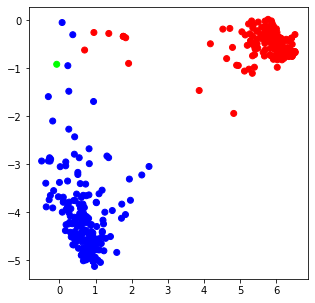


Mean Squared Error after 2 training epoch(s): 0.16898546393031522


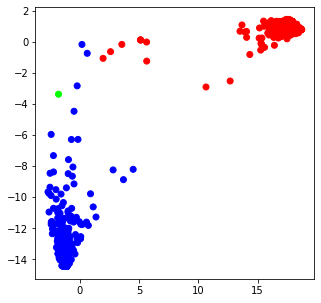


Mean Squared Error after 4 training epoch(s): 0.13407309258088163


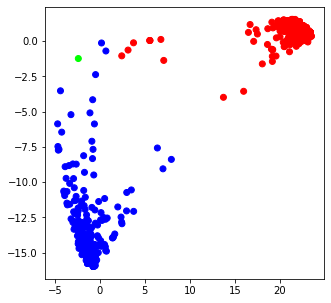


Mean Squared Error after 8 training epoch(s): 0.105573605101351


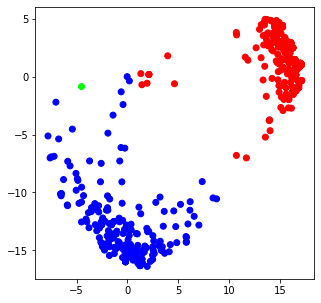


Mean Squared Error after 16 training epoch(s): 0.09523273083819311


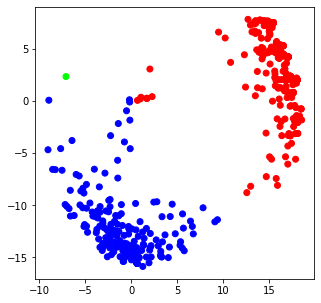


Mean Squared Error after 32 training epoch(s): 0.09043241001812644


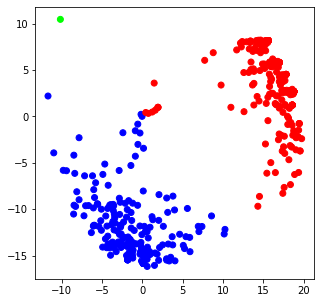


Mean Squared Error after 64 training epoch(s): 0.08498173121211611


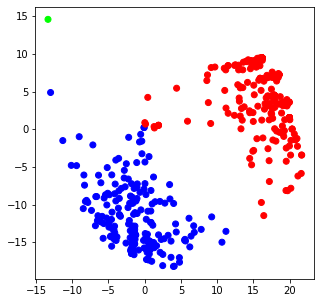


Mean Squared Error after 128 training epoch(s): 0.07663359994988343


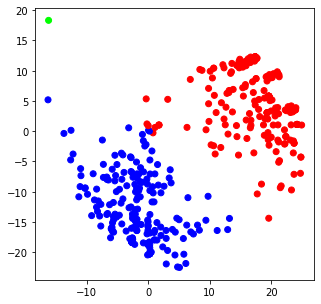


Mean Squared Error after 256 training epoch(s): 0.06619653896933733


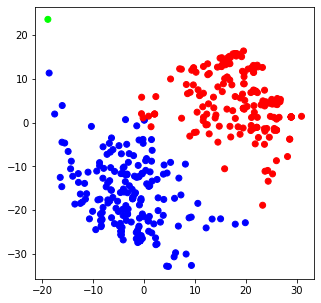


Mean Squared Error after 512 training epoch(s): 0.05279456760345514


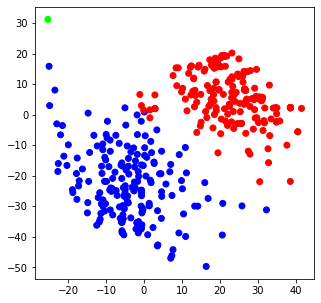


Mean Squared Error after 1024 training epoch(s): 0.04168175630269037


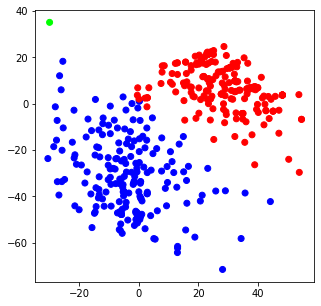

In [21]:
# show the embeddings in 2D space
def show_embeddings(X_emb, Y_emb):
  plt.rcParams["figure.figsize"] = (5,5)
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  x = X_emb[:,0]
  y = X_emb[:,1]
  cmap = {0: '#0000ff', 1: '#ff0000', 2: '#00ff00'}
  rgb = [cmap[i] for i in Y_emb.reshape((-1)).tolist()]
  ax.scatter(x, y, color=rgb)
  plt.show()

# loss function
def loss(x, x_bar):
  # mean squared error
  return tf.keras.backend.mean(tf.keras.backend.square(x-x_bar), axis=1)

# run one training epoch
def training_epoch(X_, batch_size, model, optimizer):
  num_iter = len(X_)//batch_size+1
  for i in range(num_iter):
    # get a random batch
    X_batch = X_.take(np.random.permutation(len(X_))[:batch_size], axis=0)

    # run one optimization step
    with tf.GradientTape() as tape:
      reconstruction, embedding = model(X_batch)
      loss_value = loss(X_batch, reconstruction)
      optimizer.apply_gradients(zip(tape.gradient(loss_value, model.trainable_variables), model.trainable_variables))

# compute the average loss for the validation data
def validate(X_, batch_size, model, emb_size):
  loss_total = np.empty((0,))
  embeddings = np.empty((0,emb_size))
  for i in range(0, len(X_), batch_size):
    X_batch = X_[i:i+batch_size]
    reconstruction, embedding = model.predict(X_batch)
    loss_value = loss(X_batch, reconstruction)
    loss_total = np.concatenate((loss_total, loss_value.numpy()), axis=0)
    embeddings = np.concatenate((embeddings, embedding), axis=0)
  return np.mean(loss_total), embeddings

#training loop
optimizer = tf.optimizers.Adam(learning_rate=0.001)
num_epochs = 1024
batch_size = 32

log_count = 1
for i in range(num_epochs):
  training_epoch(X, batch_size, model, optimizer)

  if i == log_count-1:
    loss_value, embeddings = validate(X, batch_size, model, embedding_size)
    print('\nMean Squared Error after {} training epoch(s):'.format(log_count), loss_value)
    show_embeddings(embeddings, Y)
    log_count *= 2

**6) Visualize the reconstruction output**

Show how well the model reconstructs the input data.


 Commish. Jenniffer González-Colón [R] / 20 votes


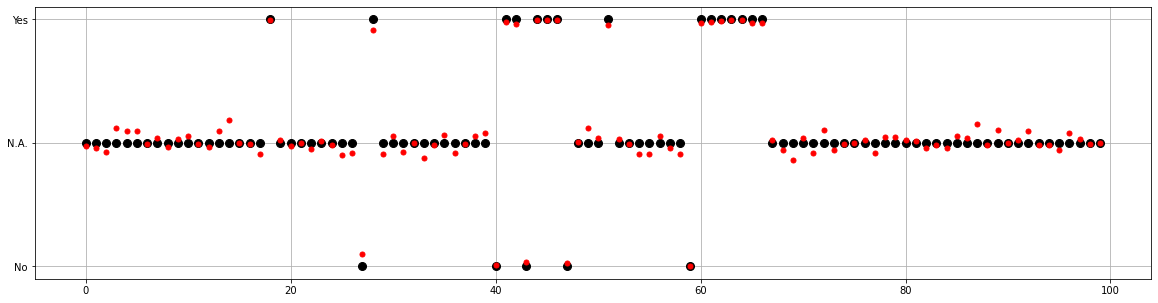


 Rep. A. Dutch Ruppersberger [D] / 97 votes


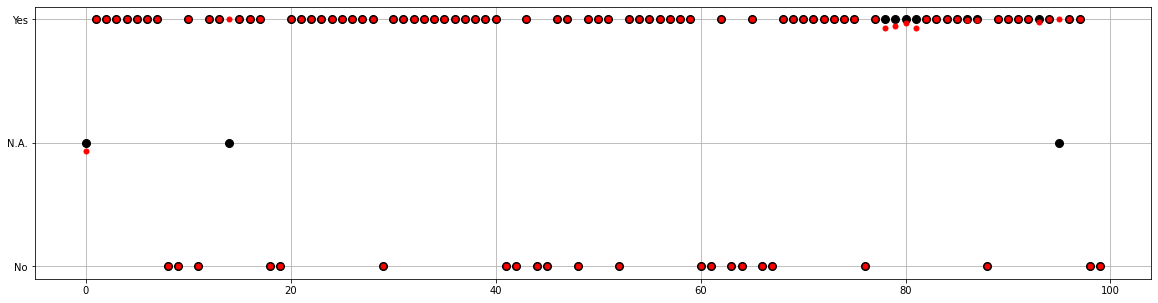


 Rep. Abby Finkenauer [D] / 98 votes


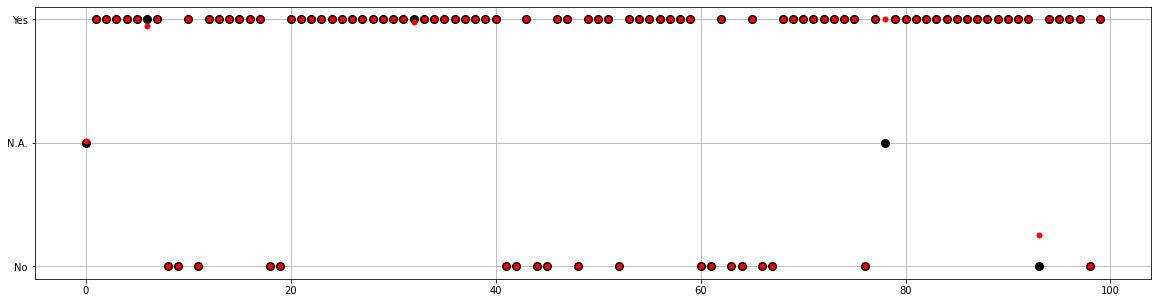


 Rep. Abigail Spanberger [D] / 98 votes


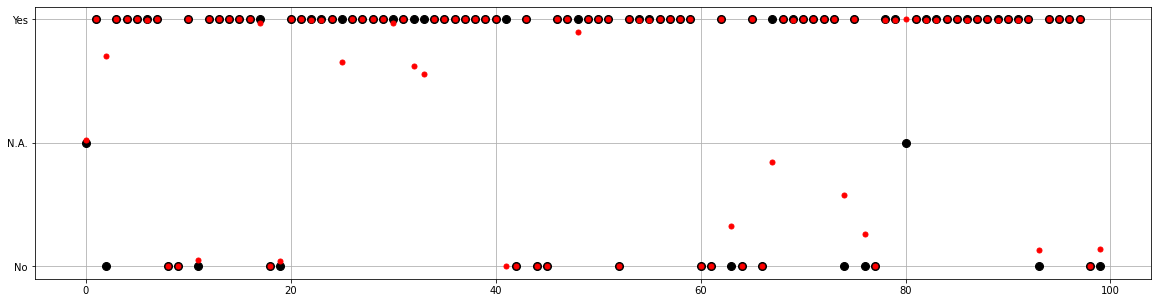


 Rep. Adam Kinzinger [R] / 76 votes


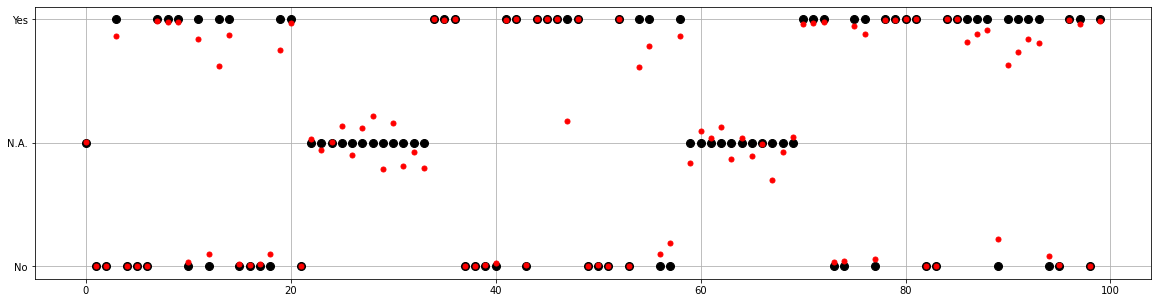


 Rep. Adam Schiff [D] / 99 votes


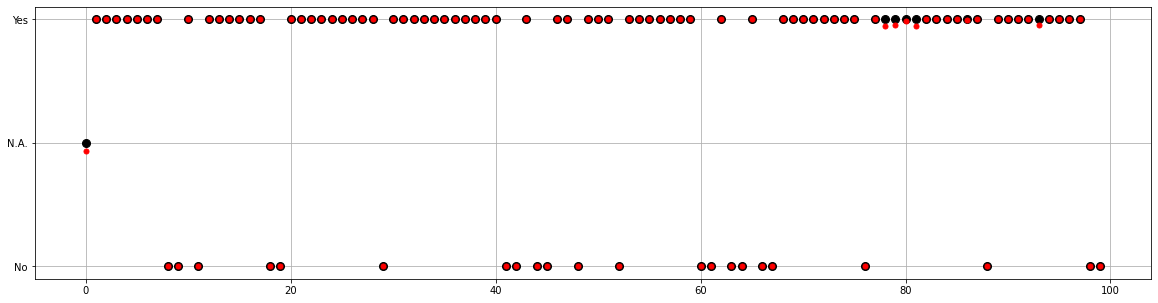


 Rep. Adam Smith [D] / 95 votes


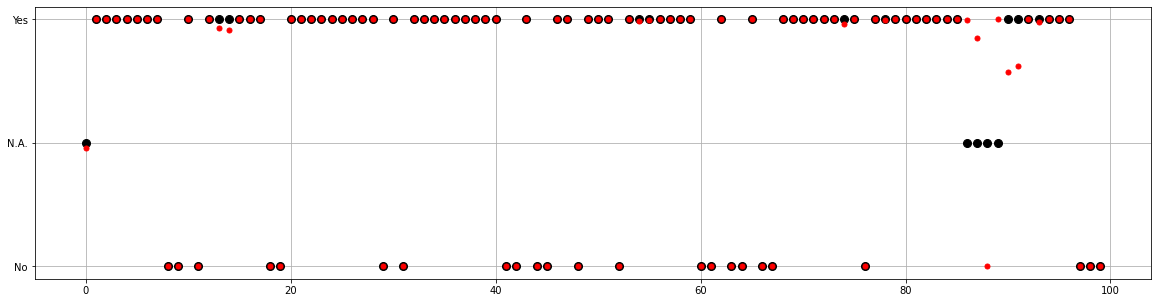


 Rep. Adrian Smith [R] / 99 votes


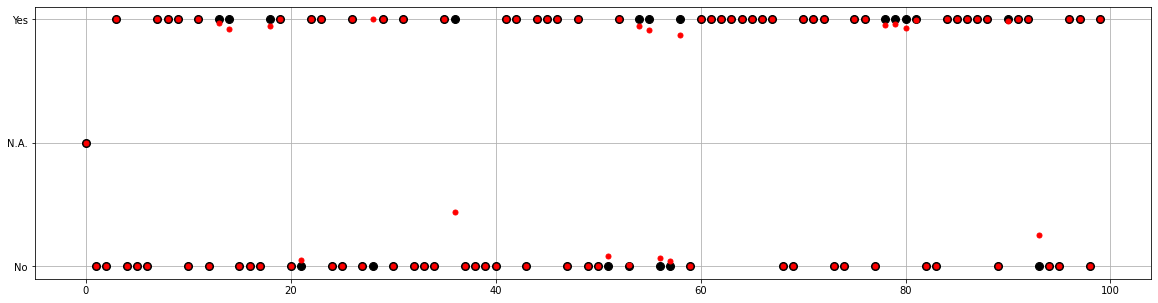


 Rep. Adriano Espaillat [D] / 99 votes


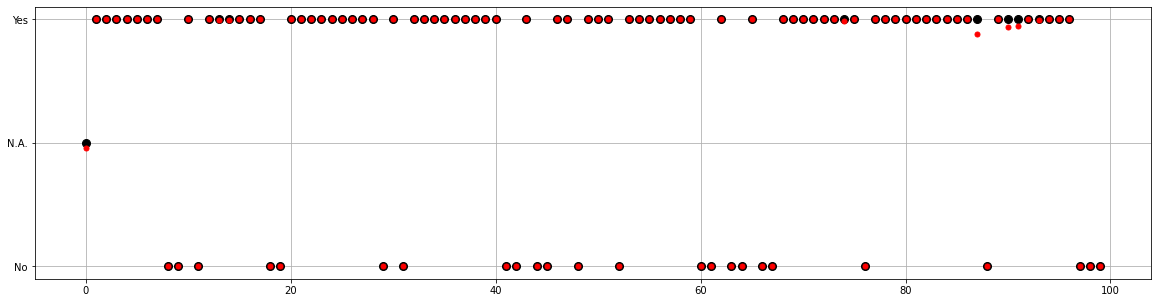


 Rep. Al Green [D] / 97 votes


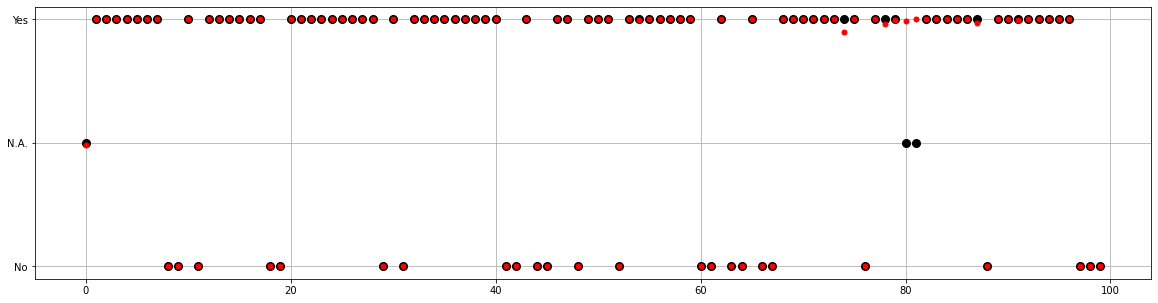

In [22]:
reconstruction = np.empty((0,N))
embedding = np.empty((0,embedding_size))
for i in range(0, len(X), batch_size):
  X_batch = X[i:i+batch_size]
  rec, emb = model.predict(X_batch)
  reconstruction = np.concatenate((reconstruction, rec), axis=0)
  embedding = np.concatenate((embedding, emb), axis=0)

# show votes of the first 3 representatives (alphabetical order)
x = [i for i in range(N)]
for i in range(10):
  print('\n', names[i], '/', np.sum(np.square(X[i])).astype(np.int64), 'votes')
  show_votes(X[i], reconstruction[i])

**7) Tasks:**

1.   Can you improve the reconstruction results (reduce reconstruction error for valid votes)?
2.   Can you find out the three representatives with the least number of valid votes and predict how they would vote in the sessions they were absent? How?
3.   Can you find out the three representatives with the highest number of unexpected votes? How?
4.   Can you use the embedding to discover the party of the representatives? How? What accuracy do you get?
5.   In question 4, what happens if you increase the embedding size to 3?
6.   Can you adapt your code to respond questions 2-5 for the senate?